In [ ]:
"""
AUDJPY carry-crash prototype
----------------------------
Build weekly AUDJPY spot & carry returns using:
  - Spot: AUDUSD, USDJPY  ->  AUDJPY_spot = AUDUSD * USDJPY
  - 1M Forward POINTS for AUDJPY (in JPY pips): convert to outright forward
  - 1M 25Δ Risk Reversal (RR) for AUDJPY: build "fear" signal from changes in RR

Then:
  - Create next-4-week (≈monthly) forward-looking return target
  - Event study on big negative moves in RR (steepening toward puts)
  - Predictive regressions with Newey–West SEs for overlap

Dependencies:
  pandas, numpy, statsmodels
"""

# ====== Imports ======
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
from statsmodels.stats.sandwich_covariance import cov_hac, se_cov

# ====== USER INPUTS (file paths & column names) ===============================
# Your CSVs (already on disk)
PATH_SPOT    = "Data/Daily_Spot_Prices_G10_FX_Pairs_Daily_2000_2025.csv"
PATH_FWDPTS  = "Data/forwards.csv"                 # contains AUDJPY 1M forward POINTS (JPY pips)
PATH_RR      = "Data/AT-32_Risk_Reversal_Daily_2005_2025.csv"                  # contains AUDJPY 1M 25Δ RR

# Column names (as they appear in your files)
COL_AUDUSD_DATE   = "AUDUSD - Date"
COL_AUDUSD_LAST   = "AUDUSD - Last Price"
COL_USDJPY_DATE   = "USDJPY - Date"
COL_USDJPY_LAST   = "USDJPY - Last Price"

COL_AUDJPY_FWDPTS_DATE = "Date"
COL_AUDJPY_FWDPTS_VAL  = "AUDJPY1M BGN Curncy  (R1)"    # points (JPY pips), not outright forward

COL_AUDJPY_RR_DATE = "Date"
COL_AUDJPY_RR_VAL  = "AUDJPY25R1M BGN Curncy  (R2)"     # 1M 25Δ risk reversal

# Analysis controls
WEEKLY_FREQ         = "W-FRI"   # resample to Friday close
HORIZON_WEEKS       = 4         # next-4-week (≈ month) return target
WARNING_QUANTILE    = 0.10      # bottom 10% dfear as "warning"
MIN_EXPANDING_WEEKS = 52        # start z-scores after ~1 year

# ====== 1) LOAD DATA =========================================================
spot_df   = pd.read_csv(PATH_SPOT)
fwdpts_df = pd.read_csv(PATH_FWDPTS)
rr_df     = pd.read_csv(PATH_RR)

# ====== 2) BUILD AUDJPY SPOT FROM AUDUSD * USDJPY ============================
# Rename for clarity and keep only what's needed
spot_df = spot_df.rename(columns={
    COL_AUDUSD_DATE: "AUDUSD_Date",
    COL_AUDUSD_LAST: "AUDUSD",
    COL_USDJPY_DATE: "USDJPY_Date",
    COL_USDJPY_LAST: "USDJPY",
})

spot_df = spot_df[["AUDUSD_Date", "AUDUSD", "USDJPY_Date", "USDJPY"]].copy()
spot_df["Date"] = pd.to_datetime(spot_df["AUDUSD_Date"], errors="coerce")

# Basic cleaning
spot_df = spot_df.drop(columns=["AUDUSD_Date", "USDJPY_Date"])
spot_df = spot_df.dropna(subset=["Date", "AUDUSD", "USDJPY"])

# AUDJPY (JPY per AUD) = (USD per AUD) * (JPY per USD)
spot_df["AUDJPY_spot"] = spot_df["AUDUSD"].astype(float) * spot_df["USDJPY"].astype(float)

# Keep tidy weekly index
audjpy_spot_w = (
    spot_df[["Date", "AUDJPY_spot"]]
    .sort_values("Date")
    .drop_duplicates("Date")
    .set_index("Date")
    .resample(WEEKLY_FREQ)
    .last()
)

# ====== 3) CONVERT AUDJPY 1M FORWARD POINTS -> OUTRIGHT FORWARD ==============
# Your series is in JPY *pips* (e.g., -54.31 means -0.5431 JPY)
fwdpts_df = fwdpts_df.rename(columns={
    COL_AUDJPY_FWDPTS_DATE: "Date",
    COL_AUDJPY_FWDPTS_VAL:  "AUDJPY_1M_points_pips",
})
fwdpts_df["Date"] = pd.to_datetime(fwdpts_df["Date"], errors="coerce")

audjpy_pts_w = (
    fwdpts_df[["Date", "AUDJPY_1M_points_pips"]]
    .sort_values("Date")
    .drop_duplicates("Date")
    .set_index("Date")
    .resample(WEEKLY_FREQ)
    .last()
)

# Replace zeros (likely “missing after export”) with NaN BEFORE math
audjpy_pts_w["AUDJPY_1M_points_pips"] = (
    audjpy_pts_w["AUDJPY_1M_points_pips"].astype(float).replace(0.0, np.nan)
)

# Join spot & points on same weeks
audjpy_df = audjpy_spot_w.join(audjpy_pts_w, how="inner")

# Convert pips -> price units: 1 pip = 0.01 JPY (for JPY crosses)
audjpy_df["AUDJPY_1M_points_price"] = audjpy_df["AUDJPY_1M_points_pips"] / 100.0

# Outright 1M forward = spot + points_in_price_units
audjpy_df["AUDJPY_1M_forward"] = (
    audjpy_df["AUDJPY_spot"] + audjpy_df["AUDJPY_1M_points_price"]
)

# ====== 4) LOAD RR AND BUILD FEAR SIGNAL ====================================
rr_df = rr_df.rename(columns={
    COL_AUDJPY_RR_DATE: "Date",
    COL_AUDJPY_RR_VAL:  "AUDJPY_RR25D",
})
rr_df["Date"] = pd.to_datetime(rr_df["Date"], errors="coerce")

audjpy_rr_w = (
    rr_df[["Date", "AUDJPY_RR25D"]]
    .dropna()
    .sort_values("Date")
    .drop_duplicates("Date")
    .set_index("Date")
    .resample(WEEKLY_FREQ)
    .last()
)

# Merge everything & drop any remaining NaNs in critical fields
audjpy_df = (
    audjpy_df
    .join(audjpy_rr_w, how="inner")
    .dropna(subset=["AUDJPY_spot", "AUDJPY_1M_forward", "AUDJPY_RR25D"])
)

# Higher = more fear. For JPY crosses, more negative RR = puts expensive => multiply by -1
audjpy_df["fear_level"] = -audjpy_df["AUDJPY_RR25D"].astype(float)

# Expanding z-score (avoids look-ahead): start after MIN_EXPANDING_WEEKS
exp_mean = audjpy_df["fear_level"].expanding(min_periods=MIN_EXPANDING_WEEKS).mean()
exp_std  = audjpy_df["fear_level"].expanding(min_periods=MIN_EXPANDING_WEEKS).std()
audjpy_df["fear_z"] = (audjpy_df["fear_level"] - exp_mean) / exp_std

# Weekly change in fear (steepening); this is the predictive variable that usually matters
audjpy_df["dfear"] = audjpy_df["fear_z"].diff()

# ====== 5) COMPUTE WEEKLY RETURNS ============================================
# Spot weekly return (percentage)
audjpy_df["ret_spot_w"] = audjpy_df["AUDJPY_spot"].pct_change()

# Annualized carry yield from forward vs spot:
# carry_yield_annual ~ ((F - S) / S) * 12  (12 months in a year)
audjpy_df["carry_yield_annual"] = (
    (audjpy_df["AUDJPY_1M_forward"] - audjpy_df["AUDJPY_spot"])
    / audjpy_df["AUDJPY_spot"]
) * 12.0

# Weekly carry approx = annual carry / 52
audjpy_df["ret_carry_w"] = audjpy_df["carry_yield_annual"] / 52.0

# Total weekly return ≈ spot move + carry
audjpy_df["ret_total_w"] = (audjpy_df["ret_spot_w"] + audjpy_df["ret_carry_w"])

# Optional sanity check (uncomment to inspect)
# print(audjpy_df[["AUDJPY_spot","AUDJPY_1M_forward","ret_total_w"]].describe(percentiles=[.01,.05,.5,.95,.99]))

# ====== 6) TARGET = NEXT 4-WEEK (≈ MONTHLY) RETURN ===========================
# Rolling sum of next HORIZON_WEEKS returns, shifted so that predictors at t map to returns t+1..t+H
h = HORIZON_WEEKS
audjpy_df["ret_next_h"] = audjpy_df["ret_total_w"].rolling(h).sum().shift(-h+1)

# Build aligned dataset and drop NaNs from early expanding windows / diffs
aligned = audjpy_df[["ret_total_w", "fear_z", "dfear", "ret_next_h"]].dropna().copy()
aligned = aligned.rename(columns={
    "ret_total_w": "ret_w",
    "ret_next_h":  "ret_next_h",
})

# ====== 7) EVENT STUDY =======================================================
# Define "warning" as bottom WARNING_QUANTILE of dfear (largest *negative* change = steepening toward puts)
q = aligned["dfear"].quantile(WARNING_QUANTILE)
warning_mask = aligned["dfear"] <= q

evt_avg_warning   = aligned.loc[warning_mask,  "ret_next_h"].mean()
evt_hit_warning   = (aligned.loc[warning_mask,  "ret_next_h"] < 0).mean()
evt_avg_nowarning = aligned.loc[~warning_mask, "ret_next_h"].mean()

print("Event study (AUDJPY):")
print(f"  Avg next-{h}w return | warning weeks: {evt_avg_warning:.4%}")
print(f"  Hit rate (<0)        | warning weeks: {evt_hit_warning:.1%}")
print(f"  Avg next-{h}w return | non-warning  : {evt_avg_nowarning:.4%}")

# ====== 8) PREDICTIVE REGRESSIONS (Newey–West SEs for overlap) ===============
y  = aligned["ret_next_h"]

# (a) Using dfear only
X1 = add_constant(aligned[["dfear"]])
ols1 = OLS(y, X1, missing="drop").fit()
nw_cov1 = cov_hac(ols1, nlags=h-1)         # lag = horizon-1 for overlapping sums
nw_se1  = se_cov(nw_cov1)
tstats1 = ols1.params / nw_se1

print(f"\nRegression: ret_next_{h}w ~ dfear (AUDJPY)")
print("Params:\n", ols1.params)
print("Newey–West t-stats:\n", tstats1)

# (b) Level of fear + change in fear
X2 = add_constant(aligned[["fear_z", "dfear"]])
ols2 = OLS(y, X2, missing="drop").fit()
nw_cov2 = cov_hac(ols2, nlags=h-1)
nw_se2  = se_cov(nw_cov2)
tstats2 = ols2.params / nw_se2

print(f"\nRegression: ret_next_{h}w ~ fear_z + dfear (AUDJPY)")
print("Params:\n", ols2.params)
print("Newey–West t-stats:\n", tstats2)

# ====== 9) OPTIONAL: DIAGNOSTIC PRINTS =======================================
# Uncomment to quickly eyeball units & scales
# print("\nSanity check — first rows (spot vs forward):")
# print(audjpy_df[["AUDJPY_spot","AUDJPY_1M_points_pips","AUDJPY_1M_points_price","AUDJPY_1M_forward"]].head(10))
# print("\nWeekly return distribution:")
# print(aligned["ret_w"].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

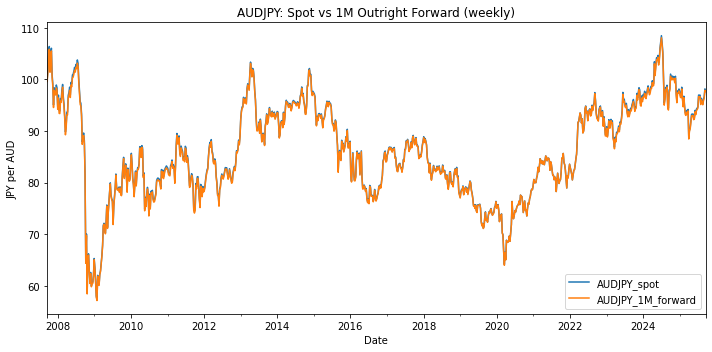

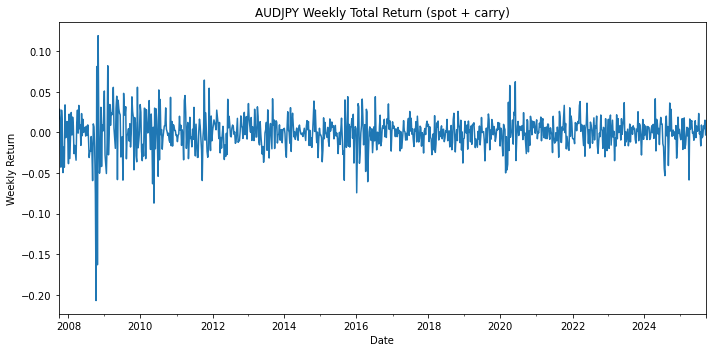

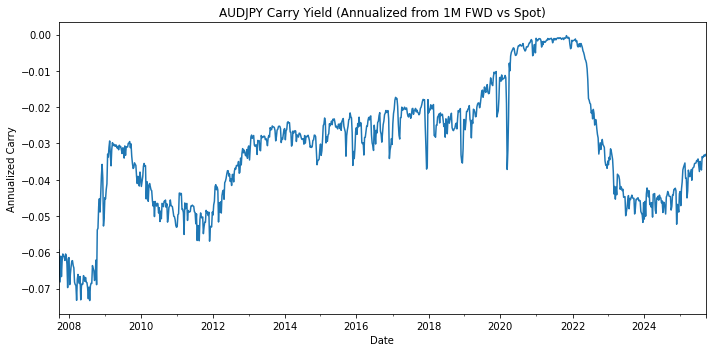

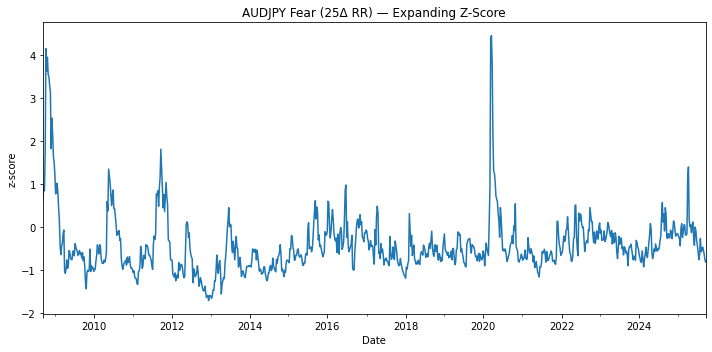

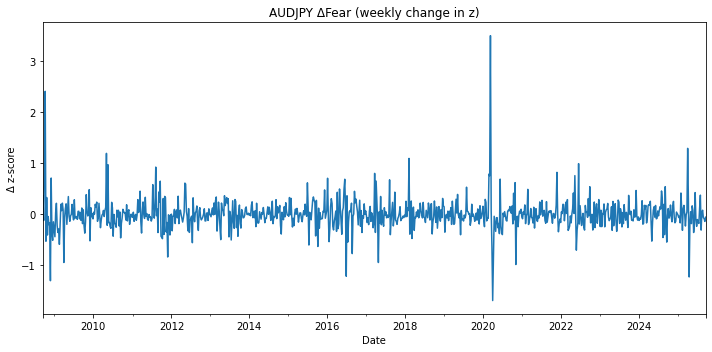

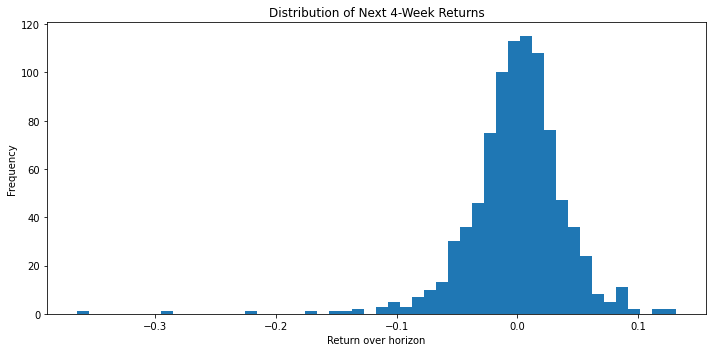

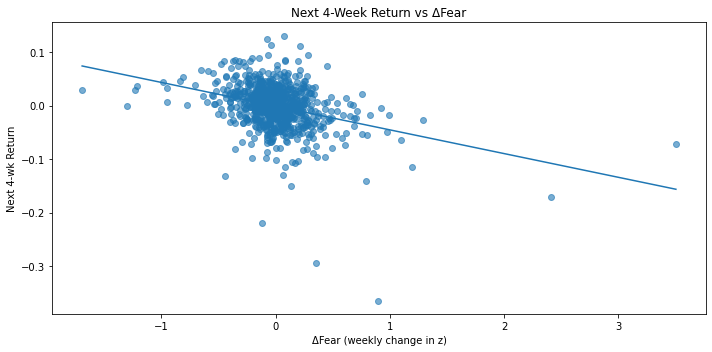

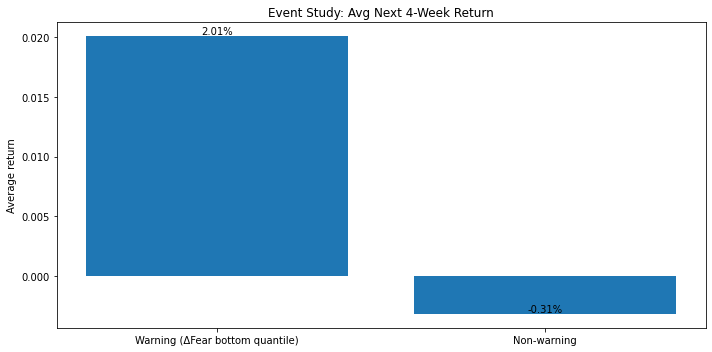

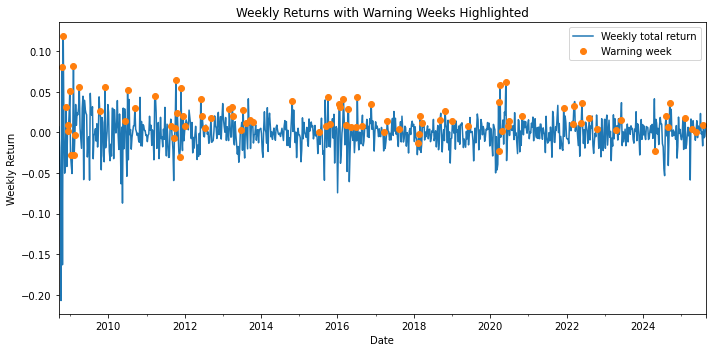

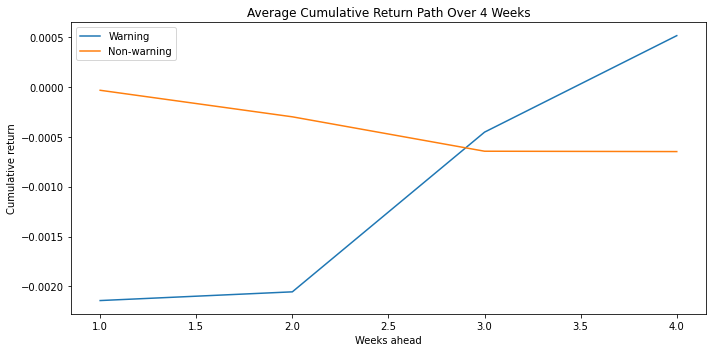

In [2]:
# ====== 10) VISUALIZATIONS ===================================================
import matplotlib.pyplot as plt
from pathlib import Path
plt.rcParams["figure.figsize"] = (10, 5)

# Create an output folder for figures (optional)
Path("figs").mkdir(exist_ok=True)

# --- 10.1 AUDJPY spot vs 1M forward (levels) ---------------------------------
fig = plt.figure()
audjpy_df[["AUDJPY_spot", "AUDJPY_1M_forward"]].dropna().plot(ax=plt.gca())
plt.title("AUDJPY: Spot vs 1M Outright Forward (weekly)")
plt.xlabel("Date")
plt.ylabel("JPY per AUD")
plt.legend()
plt.tight_layout()
plt.savefig("figs/10_1_spot_vs_forward.png", dpi=150)
plt.show()

# --- 10.2 Weekly total return time series ------------------------------------
fig = plt.figure()
audjpy_df["ret_total_w"].dropna().plot(ax=plt.gca())
plt.title("AUDJPY Weekly Total Return (spot + carry)")
plt.xlabel("Date")
plt.ylabel("Weekly Return")
plt.tight_layout()
plt.savefig("figs/10_2_ret_total_w.png", dpi=150)
plt.show()

# --- 10.3 Carry yield (annualized) time series --------------------------------
fig = plt.figure()
audjpy_df["carry_yield_annual"].dropna().plot(ax=plt.gca())
plt.title("AUDJPY Carry Yield (Annualized from 1M FWD vs Spot)")
plt.xlabel("Date")
plt.ylabel("Annualized Carry")
plt.tight_layout()
plt.savefig("figs/10_3_carry_yield_annual.png", dpi=150)
plt.show()

# --- 10.4 Fear level (z) time series -----------------------------------------
fig = plt.figure()
audjpy_df["fear_z"].dropna().plot(ax=plt.gca())
plt.title("AUDJPY Fear (25Δ RR) — Expanding Z-Score")
plt.xlabel("Date")
plt.ylabel("z-score")
plt.tight_layout()
plt.savefig("figs/10_4_fear_z.png", dpi=150)
plt.show()

# --- 10.5 ΔFear (weekly change in z) time series ------------------------------
fig = plt.figure()
audjpy_df["dfear"].dropna().plot(ax=plt.gca())
plt.title("AUDJPY ΔFear (weekly change in z)")
plt.xlabel("Date")
plt.ylabel("Δ z-score")
plt.tight_layout()
plt.savefig("figs/10_5_dfear.png", dpi=150)
plt.show()

# --- 10.6 Histogram: next-h-week returns -------------------------------------
fig = plt.figure()
aligned["ret_next_h"].plot(kind="hist", bins=50)
plt.title(f"Distribution of Next {h}-Week Returns")
plt.xlabel("Return over horizon")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figs/10_6_hist_ret_next_h.png", dpi=150)
plt.show()

# --- 10.7 Scatter: ΔFear vs next-h-week return + OLS line ---------------------
# Build X,y from already-aligned data
X_sc = aligned["dfear"].values
y_sc = aligned["ret_next_h"].values

fig = plt.figure()
plt.scatter(X_sc, y_sc, alpha=0.6)
# Simple OLS line via polyfit
beta1, beta0 = np.polyfit(X_sc, y_sc, 1)
x_line = np.linspace(np.nanmin(X_sc), np.nanmax(X_sc), 200)
y_line = beta1 * x_line + beta0
plt.plot(x_line, y_line)
plt.title(f"Next {h}-Week Return vs ΔFear")
plt.xlabel("ΔFear (weekly change in z)")
plt.ylabel(f"Next {h}-wk Return")
plt.tight_layout()
plt.savefig("figs/10_7_scatter_dfear_vs_ret_next_h.png", dpi=150)
plt.show()

# --- 10.8 Event study bar chart: warning vs non-warning -----------------------
evt_means = [
    aligned.loc[warning_mask, "ret_next_h"].mean(),
    aligned.loc[~warning_mask, "ret_next_h"].mean()
]
fig = plt.figure()
plt.bar(["Warning (ΔFear bottom quantile)", "Non-warning"], evt_means)
plt.title(f"Event Study: Avg Next {h}-Week Return")
plt.ylabel("Average return")
for i, v in enumerate(evt_means):
    plt.text(i, v, f"{v:.2%}", ha="center", va="bottom")
plt.tight_layout()
plt.savefig("figs/10_8_event_bar.png", dpi=150)
plt.show()

# --- 10.9 Timeline: mark warning weeks on returns -----------------------------
# Build a series with NaN except returns on warning weeks (for overplot)
warn_series = aligned["ret_w"].copy()
warn_series[~warning_mask] = np.nan

fig = plt.figure()
aligned["ret_w"].plot(ax=plt.gca(), label="Weekly total return")
warn_series.plot(ax=plt.gca(), linestyle="", marker="o", label="Warning week")
plt.title("Weekly Returns with Warning Weeks Highlighted")
plt.xlabel("Date")
plt.ylabel("Weekly Return")
plt.legend()
plt.tight_layout()
plt.savefig("figs/10_9_warning_weeks_on_returns.png", dpi=150)
plt.show()

# --- 10.10 Cumulative return around warning weeks (optional mini-event study) --
# For a quick look, compute simple average path of next h returns after warning vs not
# (Cumulative sum over the horizon of weekly returns starting next week.)
def avg_path(df, mask, horizon):
    # Build matrix of paths: for each t that satisfies mask, collect next horizon returns
    idx = np.where(mask.values)[0]
    mat = []
    rets = df["ret_w"].values
    for i in idx:
        if i + 1 + horizon <= len(rets):
            mat.append(rets[i+1:i+1+horizon])
    if len(mat) == 0:
        return None
    mat = np.vstack(mat)
    return np.nanmean(np.cumsum(mat, axis=1), axis=0)

path_warn = avg_path(aligned, warning_mask, h)
path_nowarn = avg_path(aligned, ~warning_mask, h)

if path_warn is not None and path_nowarn is not None:
    fig = plt.figure()
    plt.plot(range(1, h+1), path_warn, label="Warning")
    plt.plot(range(1, h+1), path_nowarn, label="Non-warning")
    plt.title(f"Average Cumulative Return Path Over {h} Weeks")
    plt.xlabel("Weeks ahead")
    plt.ylabel("Cumulative return")
    plt.legend()
    plt.tight_layout()
    plt.savefig("figs/10_10_avg_paths.png", dpi=150)
    plt.show()


### **Avenue 1: The Classical Econometrics Approach (The Path to Predictive Proof)**

This path focuses on transforming the initial concept into a rigorous, robust econometric study that can withstand academic scrutiny.

  * **Systematize the Portfolio and the "Fear" Indicator:**

      * The analysis must move beyond a single pair like AUD/JPY.
      * **Methodology:**
        1.  **Construct a Diversified Carry Portfolio:** At the start of each month, rank G10 currencies by their short-term interest rates (OIS rates). Form a portfolio that is long the top 3-4 "high-yielding" currencies and short the bottom 3-4 "low-yielding" (funding) currencies. This creates a realistic, beta-neutral carry factor return series.
        2.  **Create a Composite Skew Indicator:** The "fear" indicator should be a composite signal derived from the 25-delta risk reversals of *all* currencies in the portfolio. For example, it could be the average skew of the "high-yielders" minus the average skew of the "low-yielders." This measures the market's aggregate fear of a funding currency rally.

  * **Implement Formal Predictive Regressions:**

      * This is the core empirical test of the paper.
      * **Methodology:** Run overlapping predictive regressions of the form:
        $$R^{\text{Carry}}_{t \to t+k} = \alpha + \beta \cdot \text{SkewIndicator}_t + \gamma \cdot \text{Controls}_t + \epsilon_{t+k}$$
      * The dependent variable is the forward k-month return of the carry portfolio. The key is to show that the coefficient `β` is statistically significant and has the correct sign (a more negative skew predicts negative returns).

  * **Intensive Robustness Testing (Non-Negotiable for Top Journals):**

      * **Control Variables:** The regression must include standard control variables known to predict currency returns or risk premia: the **VIX index**, an aggregate **FX volatility index** (e.g., from JPMorgan or Deutsche Bank), the **level of the interest rate differential** itself, and the **momentum** of the carry trade strategy.
      * **Correct Standard Errors:** The use of overlapping returns requires **Newey-West standard errors** to correct for autocorrelation.
      * **Rigorous Out-of-Sample (OOS) Analysis:** This is the most critical test. The model must demonstrate predictive power on data it has not seen. The student should conduct a formal OOS forecasting exercise (e.g., using a rolling or expanding window) and show that the model with the skew indicator produces significantly lower forecast errors than a benchmark model with only the control variables.
      * **Economic Significance:** Show that a simple trading strategy that reduces exposure to the carry trade when the skew indicator flashes a warning generates statistically significant alpha. The paper must report Sharpe ratios, information ratios, and maximum drawdowns for this managed portfolio versus a simple buy-and-hold strategy.

#### **Recommended Python Packages:**

  * **For Predictive Regressions with Robust Standard Errors:**
    ```python
    import statsmodels.api as sm
    ```

-----

### **Avenue 2: The Machine Learning Approach (The Path to Non-Linear Prediction)**

This avenue reframes the problem from linear prediction to a more flexible, non-linear classification task, which is often better suited for rare and extreme events like market crashes.

  * **Frame as a "Crash Classification" Problem:**
      * **Problem Framing:** Instead of predicting the exact return, the goal is to predict the *probability* of a carry trade crash in the next month.
      * **Methodology:**
        1.  **Create a Binary Target Variable:** Define a "crash" event. For example, `Crash_{t+1} = 1` if the next month's carry portfolio return is in the bottom 10th percentile of its historical distribution, and `0` otherwise.
        2.  **Engineer a Rich Feature Set:** This is where ML excels. Go beyond just the level of the composite skew. Create a wide array of features known at time `t`:
              * **Skew Dynamics:** The 1-month and 3-month *change* in the skew indicator, the rolling standard deviation of the skew (the "volatility of skew"), and the skew's current z-score relative to its history.
              * **Skew Term Structure:** Include risk reversal signals from multiple option tenors (e.g., 1-week, 1-month, 3-month) to capture short-term versus medium-term fear.
              * **Other Market Features:** Levels and changes in the VIX, MOVE index, credit spreads (e.g., CDX HY), and broad equity market momentum.
        3.  **Build and Evaluate Models:**
              * Start with a **Logistic Regression** as a linear benchmark.
              * Implement more powerful, non-linear classifiers like **Random Forest** or **Gradient Boosting (XGBoost)**. These models can capture complex interactions and thresholds that linear models miss.
              * **Evaluate Performance:** For rare event prediction, simple accuracy is misleading. Use the **Area Under the Curve (AUC-ROC)** and **Precision-Recall curves** to evaluate the model's ability to correctly identify impending crashes without generating too many false alarms. The feature importance plots from the tree-based models will be a key output, revealing the most critical pre-crash indicators.

#### **Recommended Python Packages:**

  * **For a comprehensive machine learning toolkit:**
    ```python
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_auc_score, precision_recall_curve
    ```
  * **For a high-performance Gradient Boosting implementation:**
    ```python
    import xgboost as xgb
    ```